In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/기학25-2/mon_standard.pkl" /content/
!cp "/content/drive/MyDrive/기학25-2/unmon_standard10_3000.pkl" /content/

In [ ]:
# === 0. Imports & Settings ===
# Step 0. Imports & 기본 설정
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

# 경로/설정
MON_PATH = "mon_standard.pkl"
UNMON_PATH = "unmon_standard10.pkl"

USE_SUBLABEL = False      # True면 각 URL을 다른 클래스, False면 사이트 단위 라벨
URL_PER_SITE = 10         # 사이트당 URL 수
TOTAL_MON_URLS = 950      # 전체 monitored URL 수 (ex: 95 sites * 10 urls)
TOTAL_UNMON = 10000       # 불러올 unmonitored 샘플 수

In [ ]:
# Step 1-1. Data loading functions
def load_monitored(
    mon_path=MON_PATH,
    use_sublabel=USE_SUBLABEL,
    url_per_site=URL_PER_SITE,
    total_urls=TOTAL_MON_URLS
):
    """
    mon_standard.pkl 로부터
    X1(timestamp seq), X2(direction*size seq), y(label) 리턴
    """
    print("[Monitored] Loading:", mon_path)
    with open(mon_path, "rb") as f:
        data = pickle.load(f)

    X1, X2, y = [], [], []

    for i in range(total_urls):
        # 사이트 라벨 (0~94)
        label = i if use_sublabel else i // url_per_site

        for sample in data[i]:
            t_seq, s_seq = [], []
            for c in sample:
                dr = 1 if c > 0 else -1
                t_seq.append(abs(c))       # timestamp
                s_seq.append(dr * 512)     # 방향 * 고정 size
            X1.append(t_seq)
            X2.append(s_seq)
            y.append(label)

    y = np.array(y)
    print(f"[Monitored] Samples: {len(y)}, #Classes: {len(np.unique(y))}")
    return X1, X2, y

# Step 1-2. 시퀀스 → 10개 feature
def build_feature_df(X1, X2):
    """
    X1: list of timestamp sequences
    X2: list of direction*size sequences (+512 / -512)

    10개 feature 생성:
      1) duration
      2) inter_arrival_std
      3) cum_bytes
      4) num_bursts
      5) mean_burst_size
      6) num_in
      7) num_out
      8) out_ratio
      9) in_ratio
     10) std_outgoing_seq
    """
    rows = []

    for t_seq, s_seq in zip(X1, X2):
        t_seq = np.array(t_seq, dtype=np.float32)
        s_seq = np.array(s_seq, dtype=np.float32)

        if len(t_seq) == 0:
            rows.append([0.0] * 10)
            continue

        # 1) duration
        duration = float(t_seq.max() - t_seq.min())

        # 2) inter-arrival std
        if len(t_seq) > 1:
            inter = np.diff(t_seq)
            inter_arrival_std = float(inter.std())
        else:
            inter_arrival_std = 0.0

        # 3) cumulative packet size (마지막 누적 값)
        cum_bytes = float(s_seq.cumsum()[-1])

        # 4) bursts: 같은 방향(부호)이 연속된 구간
        bursts = []
        curr_dir = np.sign(s_seq[0])
        curr_sum = s_seq[0]

        for x in s_seq[1:]:
            d = np.sign(x)
            if d == curr_dir:
                curr_sum += x
            else:
                bursts.append(curr_sum)
                curr_dir = d
                curr_sum = x
        bursts.append(curr_sum)

        bursts = np.array(bursts, dtype=np.float32)
        num_bursts = float(len(bursts))
        mean_burst_size = float(np.abs(bursts).mean()) if len(bursts) > 0 else 0.0

        # 5) in/out count & ratio
        num_out = float(np.sum(s_seq > 0))
        num_in  = float(np.sum(s_seq < 0))
        total   = num_out + num_in if (num_out + num_in) > 0 else 1.0

        out_ratio = num_out / total
        in_ratio  = num_in / total

        # 6) outgoing 패킷 inter-arrival std
        out_times = t_seq[s_seq > 0]
        if len(out_times) > 1:
            out_inter = np.diff(out_times)
            std_outgoing_seq = float(out_inter.std())
        else:
            std_outgoing_seq = 0.0

        rows.append([
            duration,
            inter_arrival_std,
            cum_bytes,
            num_bursts,
            mean_burst_size,
            num_in,
            num_out,
            out_ratio,
            in_ratio,
            std_outgoing_seq
        ])

    cols = [
        "duration",
        "inter_arrival_std",
        "cum_bytes",
        "num_bursts",
        "mean_burst_size",
        "num_in",
        "num_out",
        "out_ratio",
        "in_ratio",
        "std_outgoing_seq"
    ]

    return pd.DataFrame(rows, columns=cols)

# Step 1-3. 실행
X1_mon, X2_mon, y_mon = load_monitored()
X_df = build_feature_df(X1_mon, X2_mon)
print("Feature shape:", X_df.shape)
print("Columns:", X_df.columns.tolist())

# 메모리 절약
del X1_mon, X2_mon
gc.collect()


[Monitored] Loading: mon_standard.pkl
[Monitored] Samples: 19000, #Classes: 95
Feature shape: (19000, 10)
Columns: ['duration', 'inter_arrival_std', 'cum_bytes', 'num_bursts', 'mean_burst_size', 'num_in', 'num_out', 'out_ratio', 'in_ratio', 'std_outgoing_seq']


0

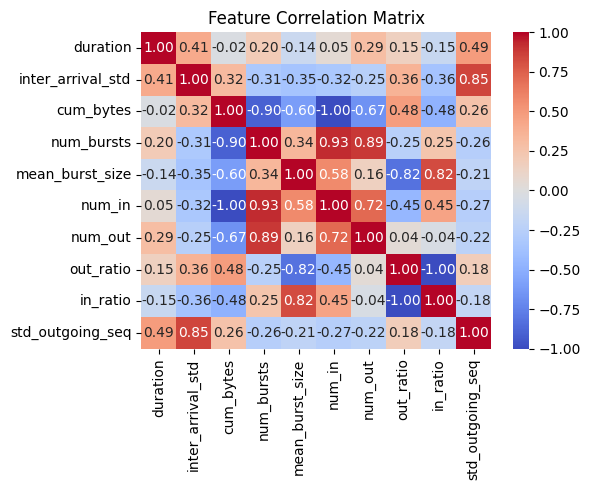

=== High correlation pairs (|r| >= 0.9) ===
cum_bytes            - num_in              : r = -0.997
num_bursts           - num_in              : r = 0.925
out_ratio            - in_ratio            : r = -1.000

[Base RF] Accuracy with all 10 features: 0.6818

=== RF Feature Importances ===
num_in               0.115203
cum_bytes            0.111607
mean_burst_size      0.106499
num_out              0.105726
inter_arrival_std    0.101110
duration             0.096330
num_bursts           0.095491
in_ratio             0.092043
out_ratio            0.091100
std_outgoing_seq     0.084891
dtype: float64


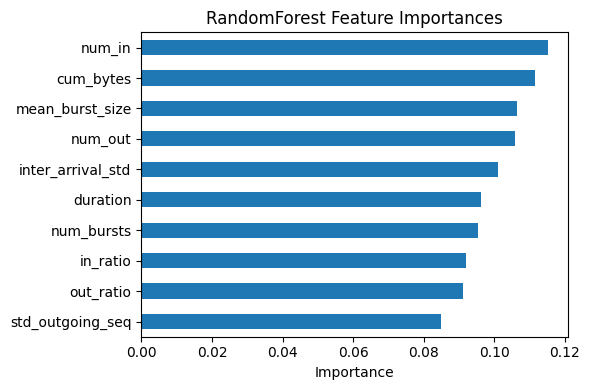

In [ ]:
# Step 2-1. 상관관계 분석
corr = X_df.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# 강한 상관관계 쌍 출력
high_corr_pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr.iloc[i, j]
        if abs(val) >= 0.9:
            high_corr_pairs.append((cols[i], cols[j], val))

print("=== High correlation pairs (|r| >= 0.9) ===")
for a, b, v in high_corr_pairs:
    print(f"{a:20s} - {b:20s}: r = {v:.3f}")

# Step 2-2. 기본 RF로 feature importance
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_df.values, y_mon,
    test_size=0.2,
    stratify=y_mon,
    random_state=42
)

rf_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_base.fit(X_train_all, y_train_all)

y_pred_base = rf_base.predict(X_test_all)
base_acc_all = accuracy_score(y_test_all, y_pred_base)
print(f"\n[Base RF] Accuracy with all 10 features: {base_acc_all:.4f}")

importances = pd.Series(rf_base.feature_importances_, index=X_df.columns).sort_values(ascending=False)
print("\n=== RF Feature Importances ===")
print(importances)

plt.figure(figsize=(6, 4))
importances.sort_values().plot(kind="barh")
plt.xlabel("Importance")
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.show()



[Ablation] Base accuracy (all 10 features): 0.6818
Removed duration           -> acc = 0.6684 (Δ = -0.0134)
Removed inter_arrival_std  -> acc = 0.6650 (Δ = -0.0168)
Removed cum_bytes          -> acc = 0.6774 (Δ = -0.0045)
Removed num_bursts         -> acc = 0.6839 (Δ = +0.0021)
Removed mean_burst_size    -> acc = 0.6739 (Δ = -0.0079)
Removed num_in             -> acc = 0.6721 (Δ = -0.0097)
Removed num_out            -> acc = 0.6747 (Δ = -0.0071)
Removed out_ratio          -> acc = 0.6824 (Δ = +0.0005)
Removed in_ratio           -> acc = 0.6818 (Δ = +0.0000)
Removed std_outgoing_seq   -> acc = 0.6658 (Δ = -0.0161)

=== Ablation summary ===
             feature  acc_after_removal     delta
0         num_bursts           0.683947  0.002105
1          out_ratio           0.682368  0.000526
2           in_ratio           0.681842  0.000000
3          cum_bytes           0.677368 -0.004474
4            num_out           0.674737 -0.007105
5    mean_burst_size           0.673947 -0.007895
6 

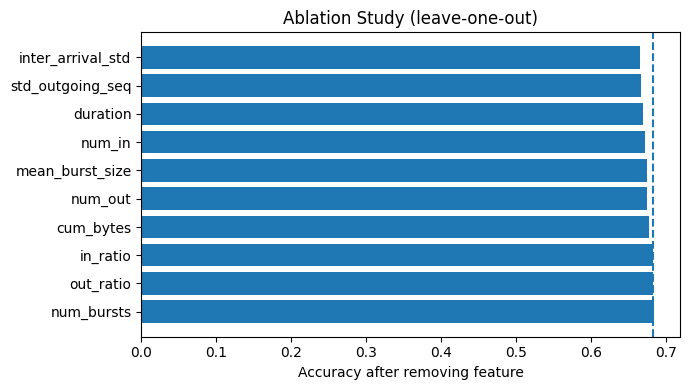

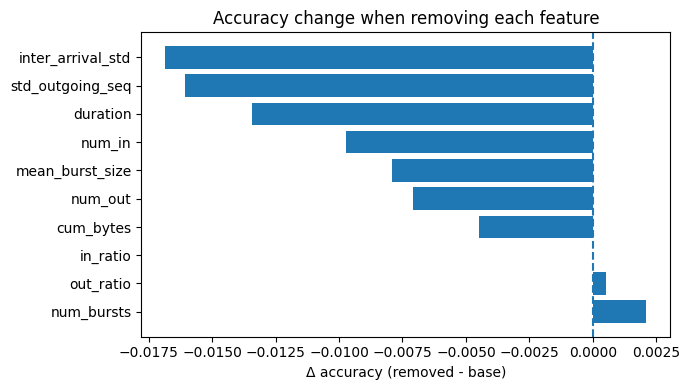

In [ ]:
# Step 3. Ablation Study (leave-one-out, 같은 분할 사용)

# train/test 분할 인덱스를 고정해서 사용
n_samples = len(y_mon)
indices = np.arange(n_samples)
idx_train, idx_test = train_test_split(
    indices,
    test_size=0.2,
    stratify=y_mon,
    random_state=42
)

def run_rf_once(feature_df, labels, idx_train, idx_test,
                rf_params=None, random_state=42):
    """같은 인덱스로 RF 학습+평가"""
    if rf_params is None:
        rf_params = {}

    X_train = feature_df.iloc[idx_train].values
    X_test  = feature_df.iloc[idx_test].values
    y_train = labels[idx_train]
    y_test  = labels[idx_test]

    clf = RandomForestClassifier(
        n_estimators=rf_params.get("n_estimators", 200),
        max_depth=rf_params.get("max_depth", None),
        min_samples_split=rf_params.get("min_samples_split", 2),
        min_samples_leaf=rf_params.get("min_samples_leaf", 1),
        max_features=rf_params.get("max_features", "sqrt"),
        random_state=random_state,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

# 3-1. 모든 feature 사용했을 때 accuracy (baseline)
base_acc = run_rf_once(X_df, y_mon, idx_train, idx_test)
print(f"\n[Ablation] Base accuracy (all 10 features): {base_acc:.4f}")

# 3-2. 하나씩 제거
ablation_results = {}
for feat in X_df.columns:
    X_ab = X_df.drop(columns=[feat])
    acc_ab = run_rf_once(X_ab, y_mon, idx_train, idx_test)
    ablation_results[feat] = acc_ab
    print(f"Removed {feat:18s} -> acc = {acc_ab:.4f} (Δ = {acc_ab - base_acc:+.4f})")

ab_df = (
    pd.DataFrame({
        "feature": list(ablation_results.keys()),
        "acc_after_removal": list(ablation_results.values())
    })
    .assign(delta=lambda df: df["acc_after_removal"] - base_acc)
    .sort_values("acc_after_removal", ascending=False)
    .reset_index(drop=True)
)

print("\n=== Ablation summary ===")
print(ab_df)

plt.figure(figsize=(7, 4))
plt.barh(ab_df["feature"], ab_df["acc_after_removal"])
plt.axvline(base_acc, linestyle="--")
plt.xlabel("Accuracy after removing feature")
plt.title("Ablation Study (leave-one-out)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.barh(ab_df["feature"], ab_df["delta"])
plt.axvline(0.0, linestyle="--")
plt.xlabel("Δ accuracy (removed - base)")
plt.title("Accuracy change when removing each feature")
plt.tight_layout()
plt.show()


In [ ]:
# Step 4. Feature Selection

importance_thr = 0.01
delta_thr = 0.01   # 1% 이상 accuracy 떨어지면 중요하다고 판단

important_by_imp = importances[importances >= importance_thr].index.tolist()
important_by_ab  = ab_df[ab_df["delta"] <= -delta_thr]["feature"].tolist()

print("Important by importance:", important_by_imp)
print("Important by ablation :", important_by_ab)

# 일단 union
selected_feats = sorted(set(important_by_imp) | set(important_by_ab))
print("\n[Step 1] Union-selected features:", selected_feats)

# 상관 높은 pair에서 중요도 낮은 쪽 제거
to_drop_corr = set()
for a, b, r in high_corr_pairs:
    if a in selected_feats and b in selected_feats:
        # 중요도 낮은 쪽 제거 후보
        if importances[a] < importances[b]:
            to_drop_corr.add(a)
        else:
            to_drop_corr.add(b)

print("From high-corr pairs, drop candidates:", to_drop_corr)

final_feats = [f for f in selected_feats if f not in to_drop_corr]
print("\n[Final selected features]:", final_feats)

# 선택된 feature만 사용
X_sel = X_df[final_feats].copy()
print("Selected feature shape:", X_sel.shape)


Important by importance: ['num_in', 'cum_bytes', 'mean_burst_size', 'num_out', 'inter_arrival_std', 'duration', 'num_bursts', 'in_ratio', 'out_ratio', 'std_outgoing_seq']
Important by ablation : ['duration', 'std_outgoing_seq', 'inter_arrival_std']

[Step 1] Union-selected features: ['cum_bytes', 'duration', 'in_ratio', 'inter_arrival_std', 'mean_burst_size', 'num_bursts', 'num_in', 'num_out', 'out_ratio', 'std_outgoing_seq']
From high-corr pairs, drop candidates: {'cum_bytes', 'num_bursts', 'out_ratio'}

[Final selected features]: ['duration', 'in_ratio', 'inter_arrival_std', 'mean_burst_size', 'num_in', 'num_out', 'std_outgoing_seq']
Selected feature shape: (19000, 7)


num_in               0.115203
mean_burst_size      0.106499
num_out              0.105726
inter_arrival_std    0.101110
duration             0.096330
in_ratio             0.092043
std_outgoing_seq     0.084891
dtype: float64
k_list: [3, 5, 7]


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



=== CV results ===
   k                                           features  cv_mean_acc  \
0  3                 [num_in, mean_burst_size, num_out]     0.306053   
1  5  [num_in, mean_burst_size, num_out, inter_arriv...     0.386105   
2  7  [num_in, mean_burst_size, num_out, inter_arriv...     0.409211   

   cv_std_acc  
0    0.034428  
1    0.045404  
2    0.047567  


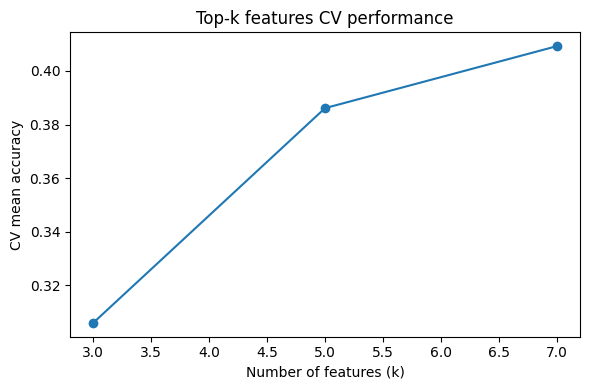

In [ ]:
# Step 5. top-k CV on selected features

# 선택된 feature들의 importance만 다시 정렬
importances_sel = importances[final_feats].sort_values(ascending=False)
print(importances_sel)

feat_rank = list(importances_sel.index)

# 사용하고 싶은 k 목록
k_list = [max(2, min(3, len(feat_rank))),  # 최소 2~3개
          min(5, len(feat_rank)),
          min(7, len(feat_rank)),
          len(feat_rank)]
k_list = sorted(list(set(k_list)))  # 중복 제거 & 정렬

print("k_list:", k_list)

cv_results = []
for k in k_list:
    topk_feats = feat_rank[:k]
    X_sub = X_sel[topk_feats].values

    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(
        clf, X_sub, y_mon,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    cv_results.append({
        "k": k,
        "features": topk_feats,
        "cv_mean_acc": scores.mean(),
        "cv_std_acc": scores.std()
    })

cv_df = pd.DataFrame(cv_results)
print("\n=== CV results ===")
print(cv_df)

plt.figure(figsize=(6, 4))
plt.plot(cv_df["k"], cv_df["cv_mean_acc"], marker="o")
plt.xlabel("Number of features (k)")
plt.ylabel("CV mean accuracy")
plt.title("Top-k features CV performance")
plt.tight_layout()
plt.show()


[duration] lower=-33.585, upper=87.495, kept 19000/19000


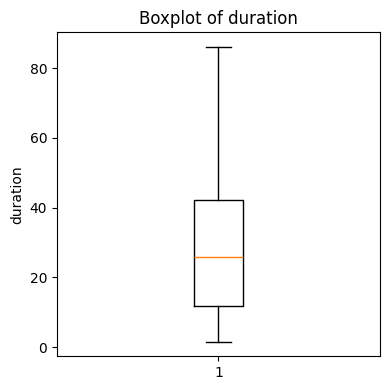

[in_ratio] lower=0.799, upper=1.017, kept 18385/19000


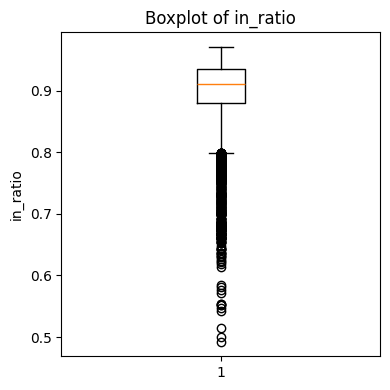

[inter_arrival_std] lower=-0.254, upper=0.537, kept 17238/19000


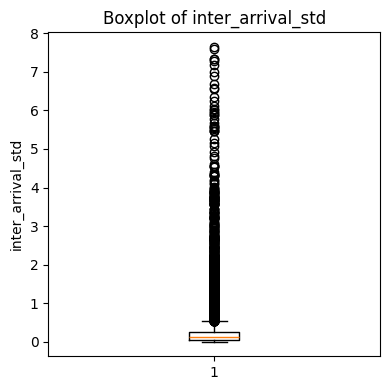

[mean_burst_size] lower=1497.104, upper=9653.241, kept 18769/19000


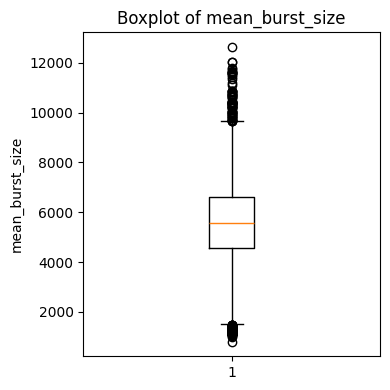

[num_in] lower=-5223.000, upper=12371.000, kept 19000/19000


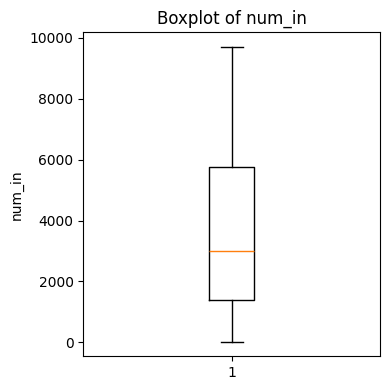

[num_out] lower=-386.500, upper=1009.500, kept 18368/19000


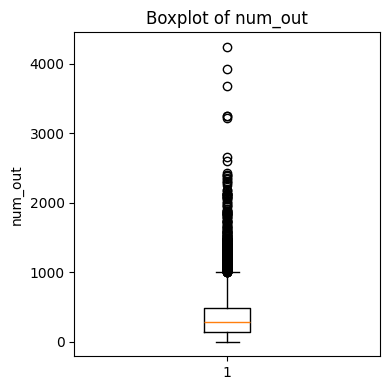

[std_outgoing_seq] lower=-0.647, upper=1.452, kept 17117/19000


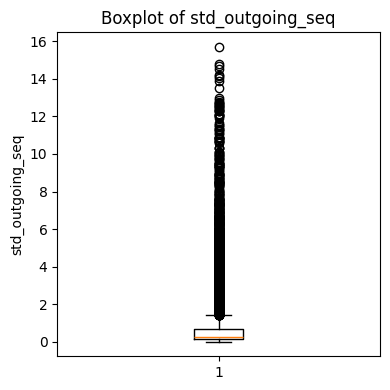


=== Outlier removal result ===
Original: 19000, After: 15576


In [ ]:
# Step 6. Outlier analysis & removal (IQR)

# 연속형 feature 위주로 지정
continuous_cols = [c for c in final_feats]  # 지금은 그냥 전부 다

mask = np.ones(len(X_sel), dtype=bool)

for col in continuous_cols:
    data = X_sel[col].values
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    col_mask = (data >= lower) & (data <= upper)
    mask = mask & col_mask

    print(f"[{col}] lower={lower:.3f}, upper={upper:.3f}, "
          f"kept {col_mask.sum()}/{len(data)}")

    plt.figure(figsize=(4, 4))
    plt.boxplot(data, vert=True)
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

X_clean = X_sel[mask].reset_index(drop=True)
y_clean = y_mon[mask]

print("\n=== Outlier removal result ===")
print(f"Original: {len(X_sel)}, After: {len(X_clean)}")


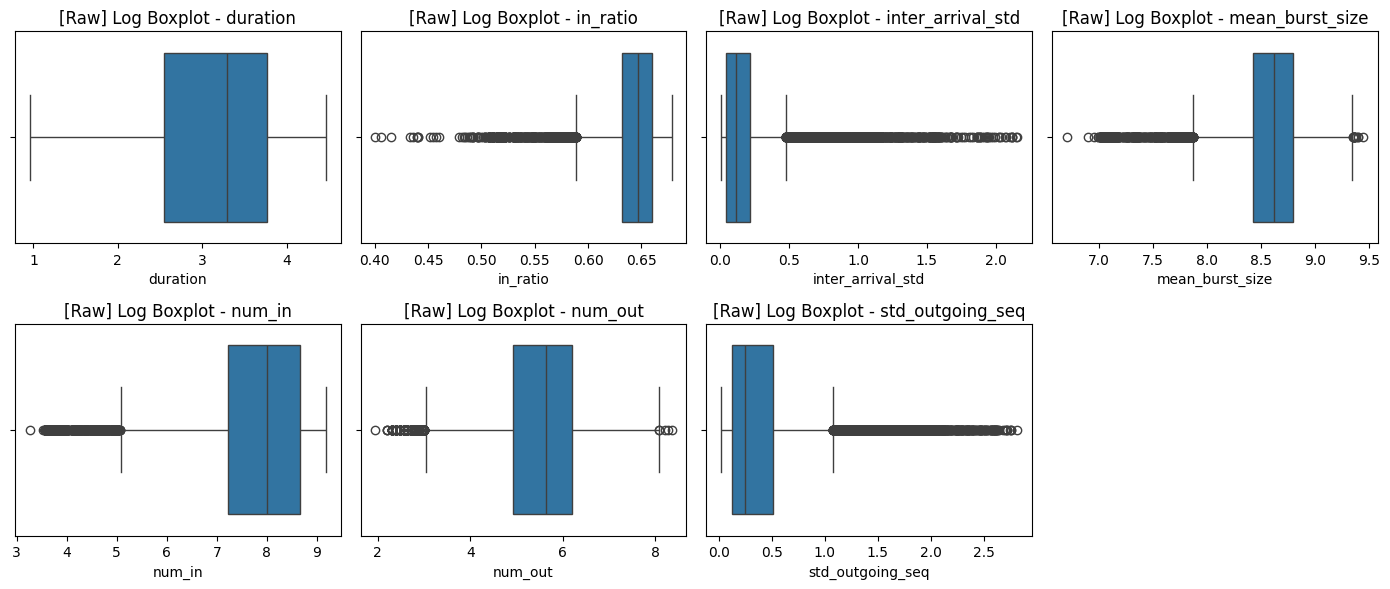

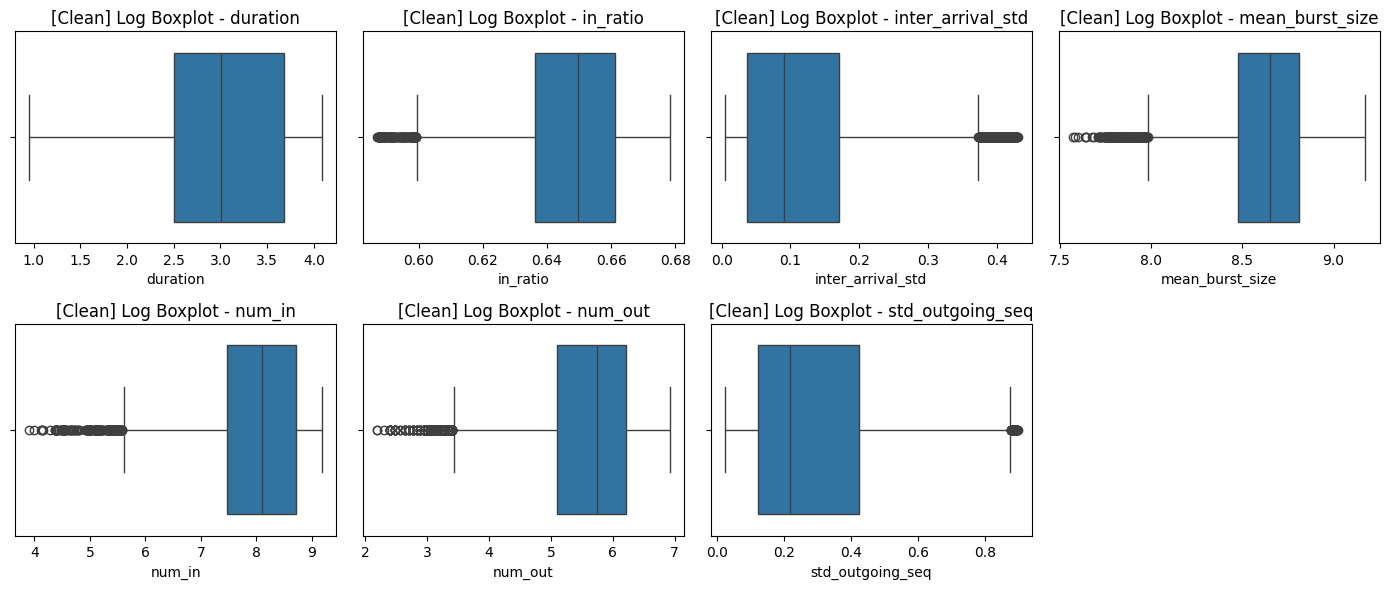

In [ ]:
# final feature들
final_features = ["duration", "in_ratio", "inter_arrival_std",
                  "mean_burst_size", "num_in", "num_out", "std_outgoing_seq"]

# 1) Outlier 제거 전: X_sel 기준
plt.figure(figsize=(14, 6))
for i, col in enumerate(final_features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=np.log1p(np.abs(X_sel[col])))
    plt.title(f"[Raw] Log Boxplot - {col}")
    plt.xlabel(col)
    plt.tight_layout()
plt.show()

# 2) Outlier 제거 후: X_clean 기준
plt.figure(figsize=(14, 6))
for i, col in enumerate(final_features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=np.log1p(np.abs(X_clean[col])))
    plt.title(f"[Clean] Log Boxplot - {col}")
    plt.xlabel(col)
    plt.tight_layout()
plt.show()

[Raw 7 features] accuracy: 0.6753
[Clean 7 features] accuracy: 0.6832


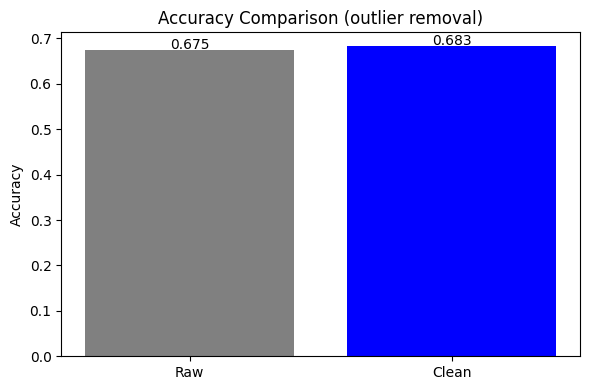

In [ ]:
# Outlier 제거 전/후 정확도 비교
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_eval_rf(X, y, label=""):
    X_train, X_test, y_train, y_test = train_test_split(
        X.values, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{label} accuracy: {acc:.4f}")
    return acc

# Raw final 7 features
acc_raw  = train_eval_rf(X_sel,   y_mon,   "[Raw 7 features]")

# Cleaned features
acc_clean = train_eval_rf(X_clean, y_clean, "[Clean 7 features]")

# Accuracy bar plot
plt.figure(figsize=(6,4))
labels = ["Raw", "Clean"]
accs   = [acc_raw, acc_clean]

plt.bar(labels, accs, color=["gray","blue"])
for i, v in enumerate(accs):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center")
plt.ylim(0, max(accs) + 0.03)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison (outlier removal)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2462563195.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-2462563195.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-2462563195.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-2462563195.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-2462563195.py:26: FutureWarni

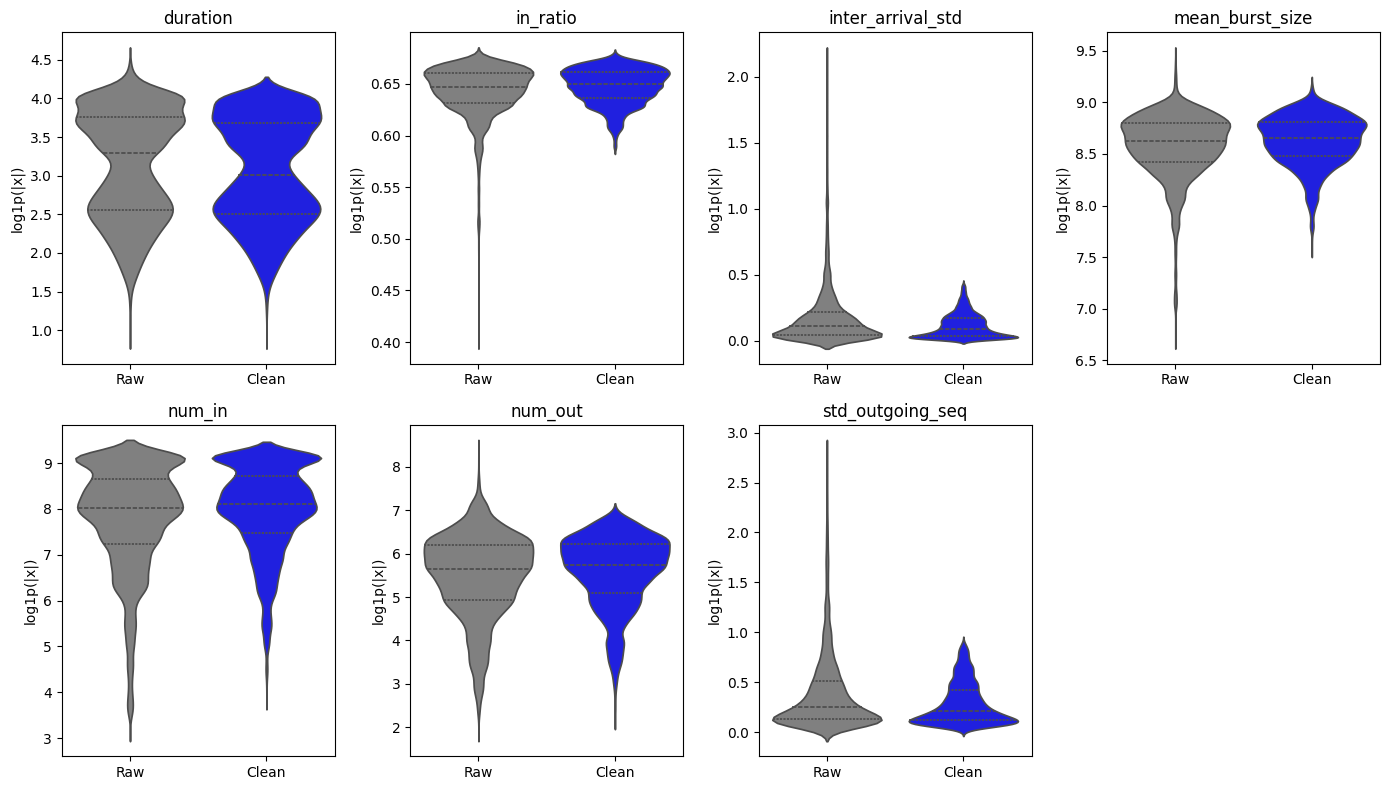

In [ ]:
# Combine raw + clean with type label
df_raw = X_sel.copy()
df_raw["type"] = "Raw"

df_clean2 = X_clean.copy()
df_clean2["type"] = "Clean"

df_all = pd.concat([df_raw, df_clean2], axis=0)

# Apply log transform
for col in final_features:
    df_all[col] = np.log1p(np.abs(df_all[col]))

# Melt transformation (long format)
df_melt = df_all.melt(id_vars="type",
                      value_vars=final_features,
                      var_name="feature",
                      value_name="value")

# Plot
plt.figure(figsize=(14, 8))

for i, col in enumerate(final_features, 1):
    plt.subplot(2, 4, i)
    df_feat = df_melt[df_melt["feature"] == col]
    sns.violinplot(
        data=df_feat,
        x="type",          # Raw vs Clean
        y="value",
        inner="quartile",
        palette=["gray", "blue"]
    )
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("log1p(|x|)")

plt.tight_layout()
plt.show()

In [ ]:
# Step 7. Hyperparameter tuning on final cleaned features

X_final = X_clean.values
y_final = y_clean

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,
    stratify=y_final,
    random_state=42
)

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_distributions = {
    "n_estimators":      [100, 200, 300, 400],
    "max_depth":         [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      ["sqrt", "log2", None],
}

rf_search = HalvingRandomSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    factor=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

print("\n=== HalvingRandomSearchCV: RF tuning on final features ===")
rf_search.fit(X_train, y_train)

print("\n=== Best Params ===")
print(rf_search.best_params_)
print("Best CV Mean Accuracy:", rf_search.best_score_)

best_rf = rf_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("\n=== Final RandomForest on Closed-world Test Set ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

print("\nConfusion Matrix:")
cm_best = confusion_matrix(y_test, y_pred_best)
print(cm_best)



=== HalvingRandomSearchCV: RF tuning on final features ===
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 950
max_resources_: 12460
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 13
n_resources: 950
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 1
n_candidates: 5
n_resources: 2850
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 2
n_candidates: 2
n_resources: 8550
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



=== Best Params ===
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Best CV Mean Accuracy: 0.6437682855471036

=== Final RandomForest on Closed-world Test Set ===
Accuracy: 0.6848523748395379

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.43      0.53        35
           1       0.59      0.52      0.55        33
           2       0.94      0.81      0.87        37
           3       0.57      0.50      0.53        34
           4       0.77      0.67      0.71        30
           5       0.84      0.89      0.86        35
           6       0.80      0.94      0.86        17
           7       0.74      0.76      0.75        38
           8       0.71      0.50      0.59        24
           9       0.52      0.62      0.57        37
          10       0.78      0.74      0.76        39
          11       0.69      0.58      0.63        31
          12      

[Raw 7 features] accuracy: 0.6753

[Clean 7 features] accuracy: 0.6832

[Tuned RF] Accuracy: 0.6848
